# Project description

Procrastinate Pro+ app has shared its data with in order to analyze the problem they are facing right now. Despite huge investments in advertising, the company has been losing money for the past few months. Our task is to understand the reasons and help the company to become profitable.
There is data about users attracted from May 1 to October 27, 2019:
- server log with data about their visits,
- clients' purchases for this period,
- advertising expenses.

We have to find out:
- where users come from and what devices they use,
- how much it costs to attract users from various advertising channels;
- how much money each client brings,
- when the cost of attracting a client pays off,
- What are the factors hindering customer acquisition?

# Processing data from a file

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import os

In [4]:
os.chdir('C:\\Users\\Владислав\\Documents\\Проекты\\datasets')

In [5]:
visits, orders, costs = (
pd.read_csv('visits_info_short.csv'),
pd.read_csv('orders_info_short.csv'),
pd.read_csv('costs_info_short.csv'))

In [6]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [7]:
#renaming the columns
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']

In [8]:
#converting data types
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [9]:
#checking for duplicates
visits.duplicated().sum()

0

In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [11]:
#renaming the columns
orders.columns = ['user_id', 'event_dt', 'revenue']

In [12]:
#converting data types
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [13]:
#checking for duplicates
orders.duplicated().sum()

0

In [14]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [15]:
costs.columns = costs.columns.str.lower()

In [16]:
#changing data type
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [17]:
#checking for duplicates
costs.duplicated().sum()

0

# Setting up functions for calculating LTV, ROI, Retention rate and Conversion

In [18]:
# function for setting up clients' profiles

def get_profiles(sessions, orders, ad_costs):

    # first visit
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # for cohort analysis let's find out months of first clients' visits
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # determining paying clients
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # calculating number of unique clinets
    # from the same marketing channel and acquisition date
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # merging costs and clients
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # calculating acquisition costs
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # дadding the costs to clients' profiles
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # cost of clients' coming from organic sources equals zero
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [19]:
# retention rate function

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # adding 'payer' column to dimensions list
    dimensions = ['payer'] + dimensions

    # excluding clients that haven't "survived" to observation date
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # raw data for calculating retention rate
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # grouping function
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # a retention rate table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # a table of retention dynamics
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # returning both tables and raw data
    return result_raw, result_grouped, result_in_time

In [20]:

# conversion function

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # excluding clients that haven't "survived" to observation date
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # determining the date and time of the first purchase for each user
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # adding purchase info to clients' profiles
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # calculating the lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # grouping by cohort, if dimensions equal zero
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # grouping function
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # deviding each cell by cohort's size
        # and getting conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # a conversion table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    
    if 'cohort' in dimensions: 
        dimensions = []

    # a table of conversion dinamics
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # returning both tables and raw data
    return result_raw, result_grouped, result_in_time

In [21]:
# functions for calculating LTV and ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # excluding clients that haven't "survived" to observation date
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # adding purchase info to profiles
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # calculate the user's lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # group by cohort, if dimensions equal zero
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # grouping function
    def group_by_dimensions(df, dims, horizon_days):
        # building a "triangular" revenue table
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # finding the amount of revenue with accumulation
        result = result.fillna(0).cumsum(axis=1)
        # finding cohorts' sizes
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # combine cohort sizes and revenue table
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # calculating LTV
        result = result.div(result['cohort_size'], axis=0)
        
        result = result[['cohort_size'] + list(range(horizon_days))]
        
        result['cohort_size'] = cohort_sizes

        # collect dataframe with user data and values CAC, 
        # add dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # calculating CAC by dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # calculating ROI
        roi = result.div(cac['cac'], axis=0)

        # remove rows with infinite ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # restoring cohort sizes in the ROI table
        roi['cohort_size'] = cohort_sizes

        # adding CAC to ROI
        roi['cac'] = cac['cac']

        # in the final table we leave the sizes of cohorts, CAC
        # ROI in lifetimes not exceeding the analysis horizon
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # returning LTV and ROI
        return result, roi

    # returning LTV and ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # remove 'cohort' from dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # returning LTV and ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # raw data
        result_grouped,  # LTV table
        result_in_time,  # dynamic LTV
        roi_grouped,  # ROI table
        roi_in_time,  # dynamic ROI
    )

In [22]:
# frame smoothing function

def filter_data(df, window):
    # for each column apply a moving average
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [23]:
# retention visualization function

def plot_retention(retention, retention_history, horizon, window=7):

    # setting fig size
    plt.figure(figsize=(15, 10))

    # exclude cohort sizes and first day retention
    retention = retention.drop(columns=['cohort_size', 0])
    # in the table of dynamics we leave only the necessary lifetime
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # if in retention table indexes only payer,
    # add another parameter — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention Rate for Paying Customers')

    
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention Rate for Non-Paying Customers')

    
    ax3 = plt.subplot(2, 2, 3)
    
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # filtering data and plotting
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition Date')
    plt.title(
        'Paying Users Retention Dynamics on Day {}'.format(
            horizon
        )
    )

    
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # filtering data and plotting
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Acquisition Date')
    plt.title(
        'Non-Paying Users Retention Dynamics on Day {}'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [25]:
# conversion visualization function

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # setting fig size
    plt.figure(figsize=(15, 5))

    # excluding cohorts' sizes
    conversion = conversion.drop(columns=['cohort_size'])
    # in the table of dynamics we leave only the necessary lifetime
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Conversion')

    
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition date')
    plt.title('Users Conversion on Day {}'.format(horizon))

    plt.tight_layout()
    plt.show()

In [26]:
# LTV and ROI visualization function

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # setting fig size
    plt.figure(figsize=(20, 10))

    # excluding cohorts' sizes
    ltv = ltv.drop(columns=['cohort_size'])
    #in the table of dynamics we leave only the necessary lifetime
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # write the cost of attraction in a new frame
    cac_history = roi_history[['cac']]

    # excluding cohorts' sizes and CAC
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # in the table of dynamics we leave only the necessary lifetime
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')

    
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition date')
    plt.title('LTV Dynamics on Day {}'.format(horizon))

    
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition date')
    plt.title('User Acquisition Cost Dynamics')

    
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback level')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')

    
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback level')
    plt.xlabel('Acquisition date')
    plt.title('ROI Dynamics on Day {}'.format(horizon))

    plt.tight_layout()
    plt.show()

# Exploratory data analysis

In [27]:
# setting up users' profiles
profiles = get_profiles(visits, orders, costs)
print(profiles.head(5))

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


In [28]:
profiles['dt'].max()

datetime.date(2019, 10, 27)

In [29]:
profiles['dt'].min()

datetime.date(2019, 5, 1)

In [30]:
#building a table reflecting the number of users and the share of paying users from each country
profiles.groupby('region').agg({'user_id':'nunique', 'payer':'mean'})\
.rename(columns={"user_id":"users_total", "payer":"paying_users"})\
.style.format("{:.1%}", subset='paying_users')


,users_total,paying_users
region,,
France,17450,3.8%
Germany,14981,4.1%
UK,17575,4.0%
United States,100002,6.9%


In [31]:
#building a table reflecting the number of users and the share of paying users for each type of device
profiles.groupby('device').agg({'user_id':'nunique', 'payer':'mean'})\
.rename(columns={"user_id":"users_total", "payer":"paying_users"})\
.style.format("{:.1%}", subset='paying_users')

,users_total,paying_users
device,,
Android,35032,5.9%
Mac,30042,6.4%
PC,30455,5.0%
iPhone,54479,6.2%


In [32]:
#building a table reflecting the number of users and the share of paying users from each marketing channel
profiles.groupby('channel').agg({'user_id':'nunique', 'payer':'mean'})\
.rename(columns={"user_id":"users_total", "payer":"paying_users"})\
.style.format("{:.1%}", subset='paying_users')

,users_total,paying_users
channel,,
AdNonSense,3880,11.3%
FaceBoom,29144,12.2%
LeapBob,8553,3.1%
MediaTornado,4364,3.6%
OppleCreativeMedia,8605,2.7%
RocketSuperAds,4448,7.9%
TipTop,19561,9.6%
WahooNetBanner,8553,5.3%
YRabbit,4312,3.8%


Our users  came from the following regions: USA, France, Germany and UK. The largest number of users in general, as well as paying users, came from the United States. The next countries by share of paying users are Germany, UK and France. Most customers use iPhone and Android. However, if we consider the share of paying users, then Mac users come out on top. As for acquisition channels, the leaders in terms of the share of paying users are FaceBoom, AdNoneSense, lambdaMediaAds. The largest number of users come through organic search, where the share of paying customers is the smallest.

# Marketing

In [33]:
#calculating the total cost of marketing
costs['costs'].sum()

105497.30000000002

In [34]:
#calculating the total cost of marketing for each channel
costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending = False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


In [36]:
costs['month'] = pd.to_datetime(costs['dt']).dt.month
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week

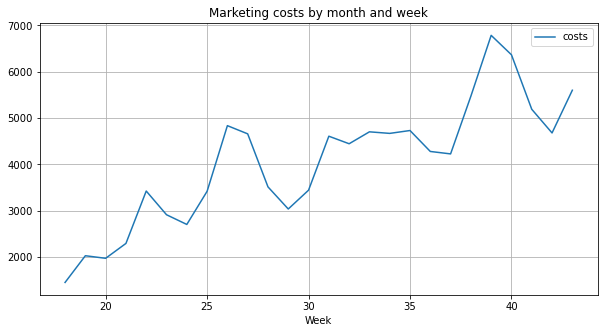

In [37]:
# plotting marketing costs
costs.groupby(['week']).agg({'costs':'sum'}).plot(figsize=(10,5), grid=True)

plt.legend()
plt.xlabel('Week')
plt.title('Marketing costs by month and week');

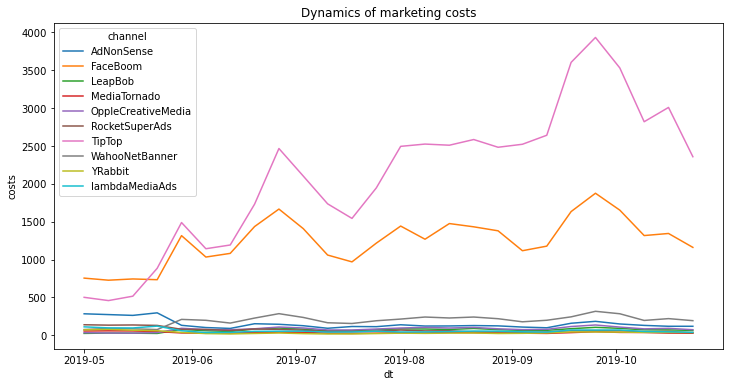

In [38]:
#plotting marketing costs by channels
fig = plt.figure(figsize=(12,6))
sns.lineplot(
    data = costs.assign(dt=pd.to_datetime(costs['dt']))\
             .set_index("dt").groupby([pd.Grouper(freq='7D'),"channel"])\
             .agg({"costs":"sum"}).reset_index(),
    x="dt",
    y="costs",
    hue="channel").set(title="Dynamics of marketing costs");

In [39]:
#calculate the average cost of customer acquisition
profiles.query("channel != 'organic'")['acquisition_cost'].mean()

1.127481323942928

In [40]:
#calculate the average cost of customer acquisition by channels
profiles.groupby('channel').agg({'acquisition_cost':'mean'}).sort_values(by='acquisition_cost')

,acquisition_cost
channel,
organic,0.000000
LeapBob,0.210172
MediaTornado,0.218717
YRabbit,0.218975
OppleCreativeMedia,0.250000
RocketSuperAds,0.412095
WahooNetBanner,0.602245
lambdaMediaAds,0.724802
AdNonSense,1.008054


The total marketing costs for this period amounted to 105497.3. We invested the most in the following acquisition channels: TipTop, FaceBoom, WahooNetBanner. At the same time, TipTop's share of spending has grown since June compared to other traffic sources. Cost peaks occur at the end of June - beginning of July (week 26-27), then in August (week 32-34) and reaches a peak at the end of September (week 39).

The average cost of attracting one client was 1.1. The most expensive acquisition channels (per user) were TipTop, FaceBoom, AdNoneSense.

# Ananlyzing marketing costs

### Analyzing the overall return on advertising

In [41]:
observation_date = datetime(2019, 11, 1).date()  # moment of analysis
horizon_days = 14  # analysis horizon

In [42]:
profiles = profiles.query('channel != "organic"')

In [43]:
# сcalculating LTV and ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

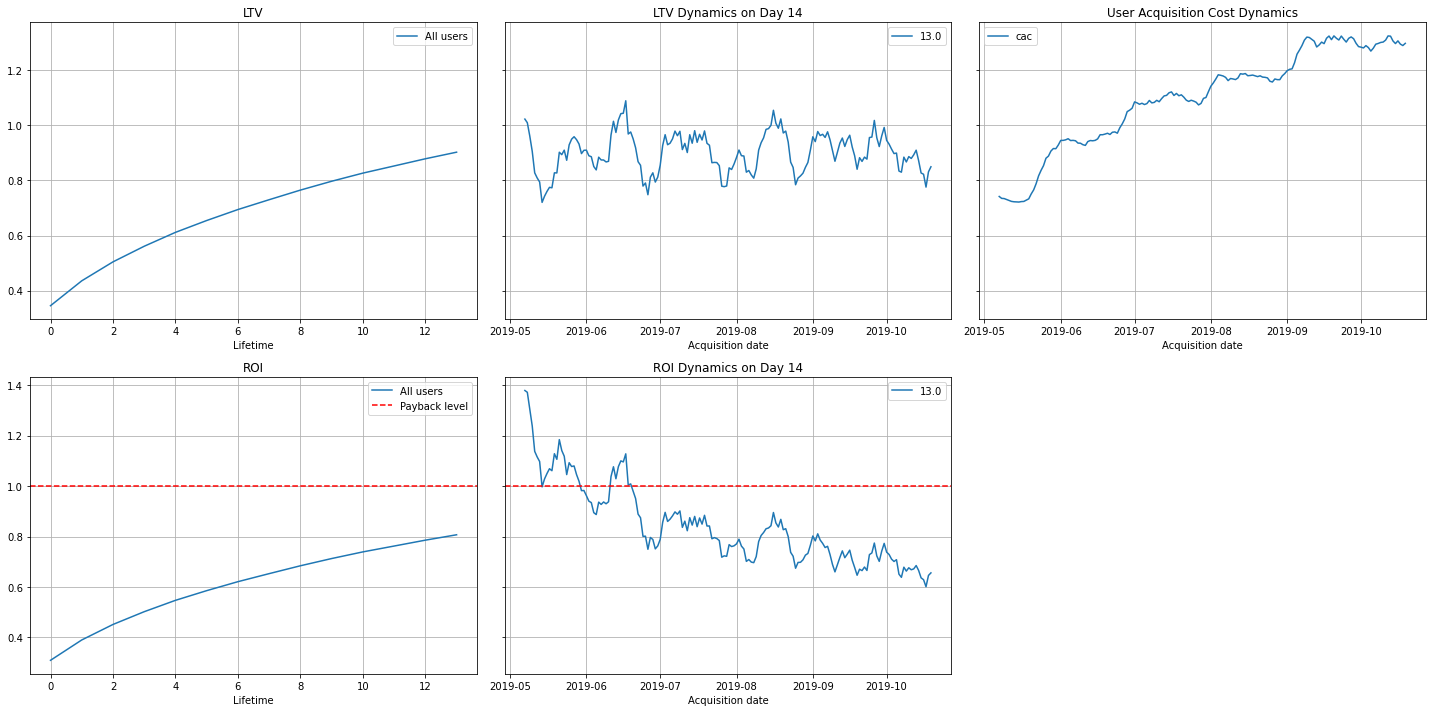

In [44]:
# plotting
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

We can draw preliminary conclusions:

- Advertising paid off until 06-2019, then there was a period in the middle of the month when it paid off, but since mid-June, the cost of attraction has been steadily growing and ROI has been falling. ROI at the end of the week is slightly above 80%
- CAC is growing, which means that there are problems with the cost of user acquisition
- LTV is consistently volatile, subject to seasonality

We need to identify which customers are costing us too much.

### Analyze ad LTV and ROI by device

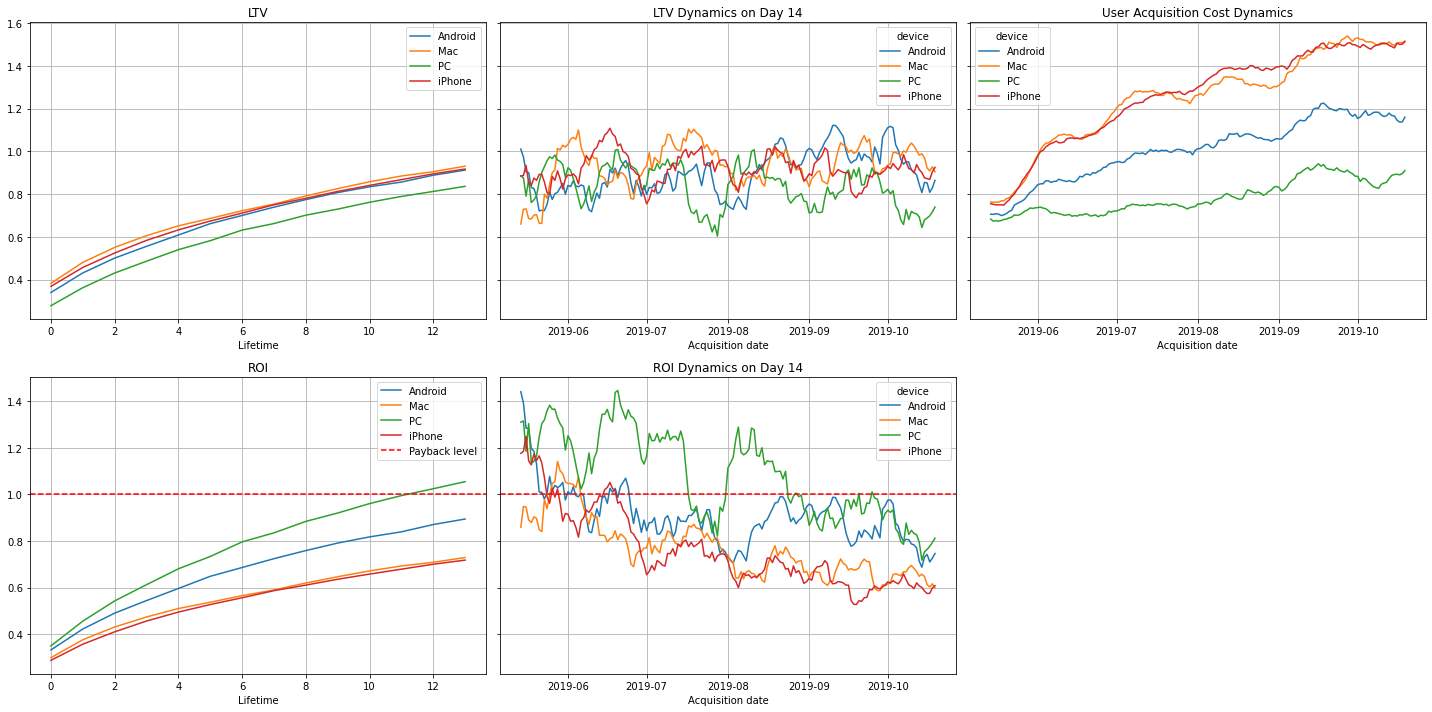

In [45]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

The charts tell us the following:

- Only PC users pay off on the 13th day
- The cost of acquisition is most stable for PC users, however, it also starts to grow from September
- Cost of acquisition for Mac, iPhone users is skyrocketing
- LTV is relatively stable

### Analyze ad LTV and ROI by country

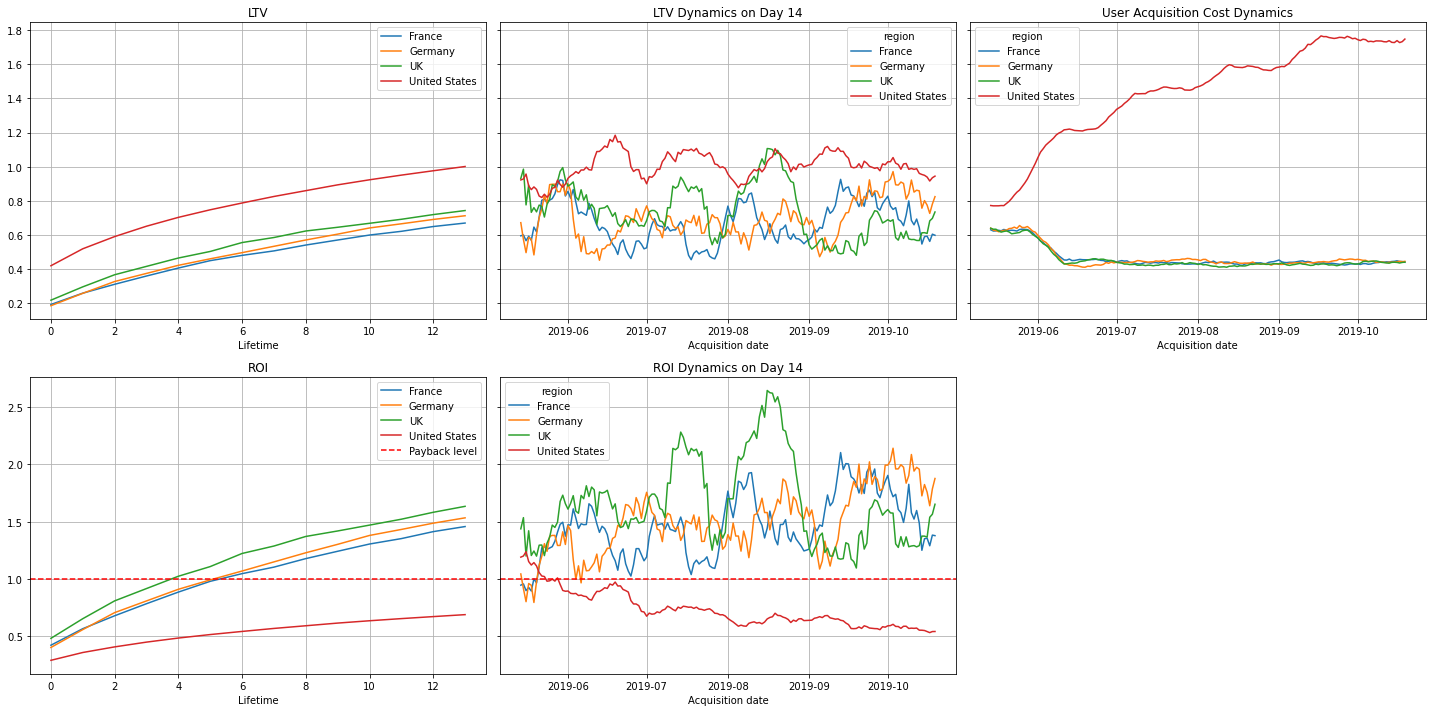

In [46]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

By country, we see more positive points:

- Advertising for users from Germany, Britain, France pay off
- The cost of attracting users from the US is so high that the cost of advertising in this region does not pay off
- As for the dynamics of the cost of attracting, since mid-May, the cost of customers from the United States has been growing rapidly, and since the end of the same month, there has been a decrease in the cost of attracting customers from other regions

### Analyze ad LTV and ROI by marketing channels

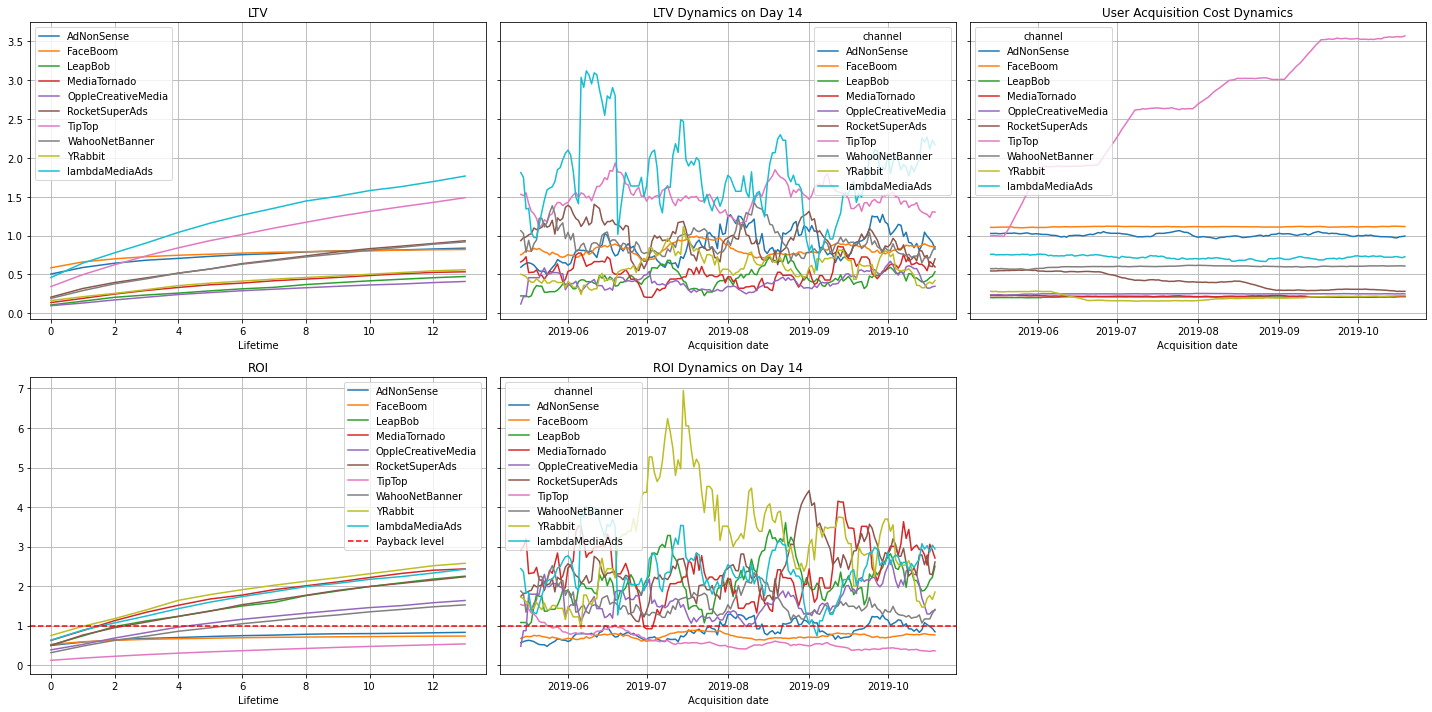

In [47]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

As for the marketing channels, the following conclusions can be drawn here:

- TipTop, FaceBoom, AdNoneSense channels are unprofitable. YRabbit, MediaTornado, lambdaMediaAds channels have good ROI
- TipTop and lambdaMediaAds lead in LTV
- In addition, the cost of attracting TipTop users is skyrocketing
- The cost of acquisition through other channels is stable

### Analyzing conversion and retention charts

#### Analyzing conversion and retention charts by channels

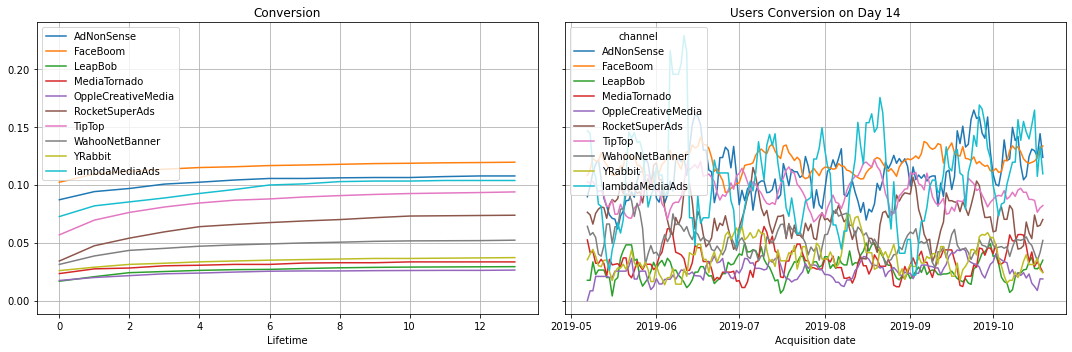

In [48]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

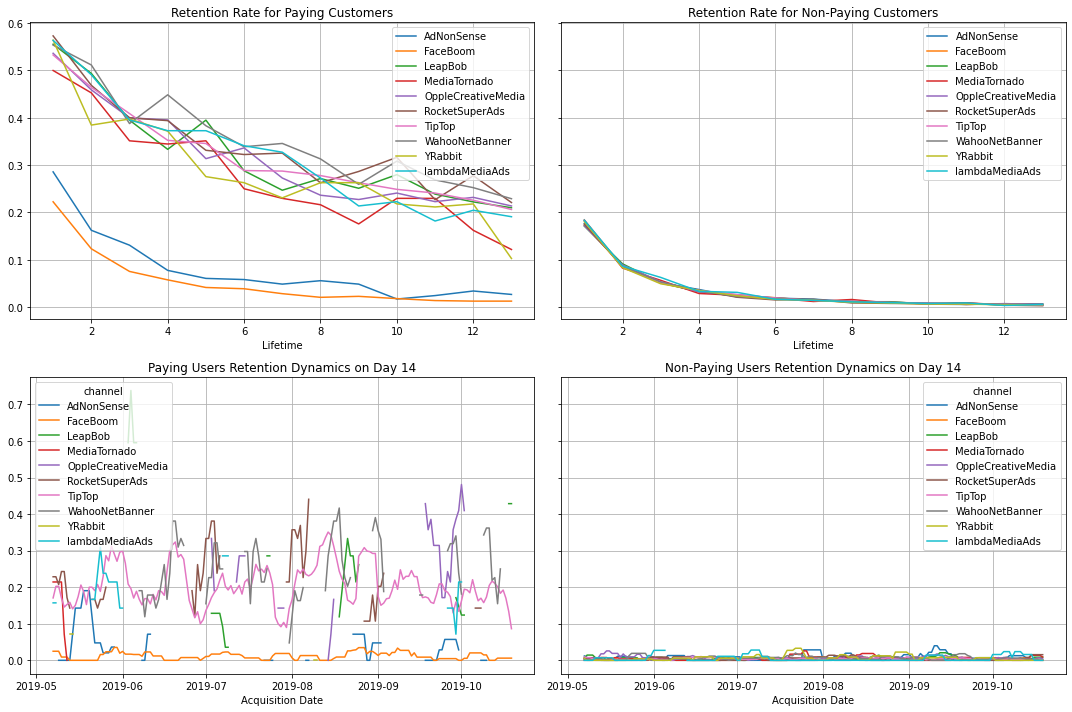

In [49]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days)

Users of the FaceBoom and AdNoneSense channels convert the best. User retention from these channels is the lowest, at day 14 it is significantly lower than that of users from other marketing channels.

#### Analyzing conversion and retention charts by countries

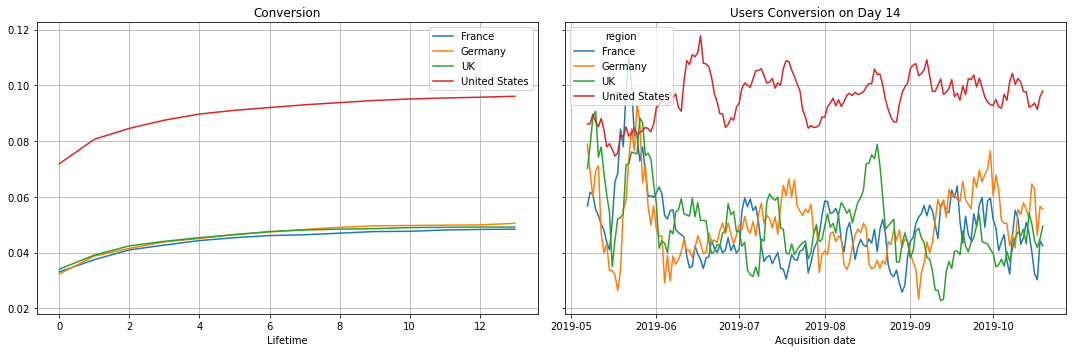

In [50]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

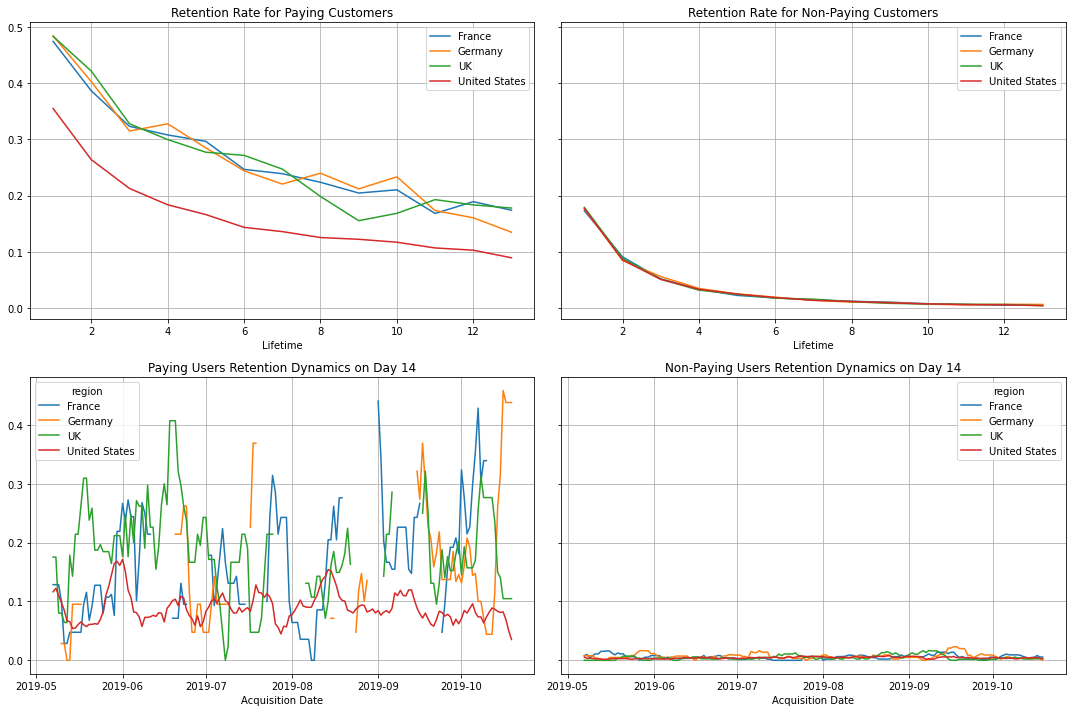

In [51]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days)

Although US users convert better than other regions, their retention leaves a lot to be desired. The retention of paying US users is significantly lower than that of users from other regions.

#### Analyzing conversion and retention charts by devices

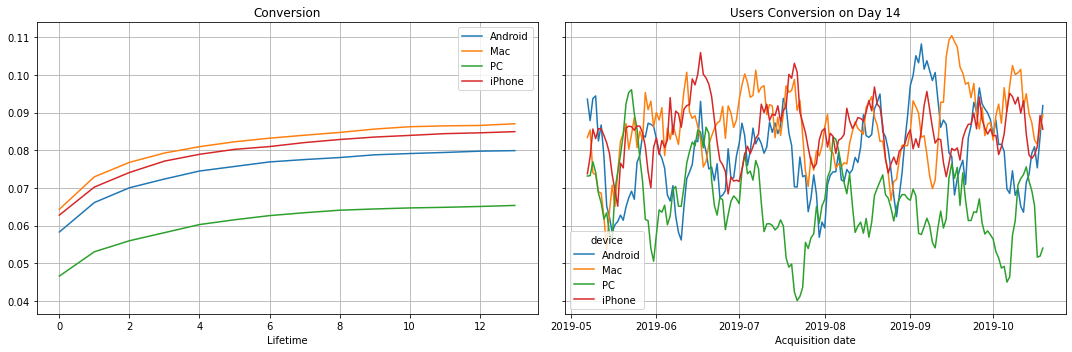

In [52]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

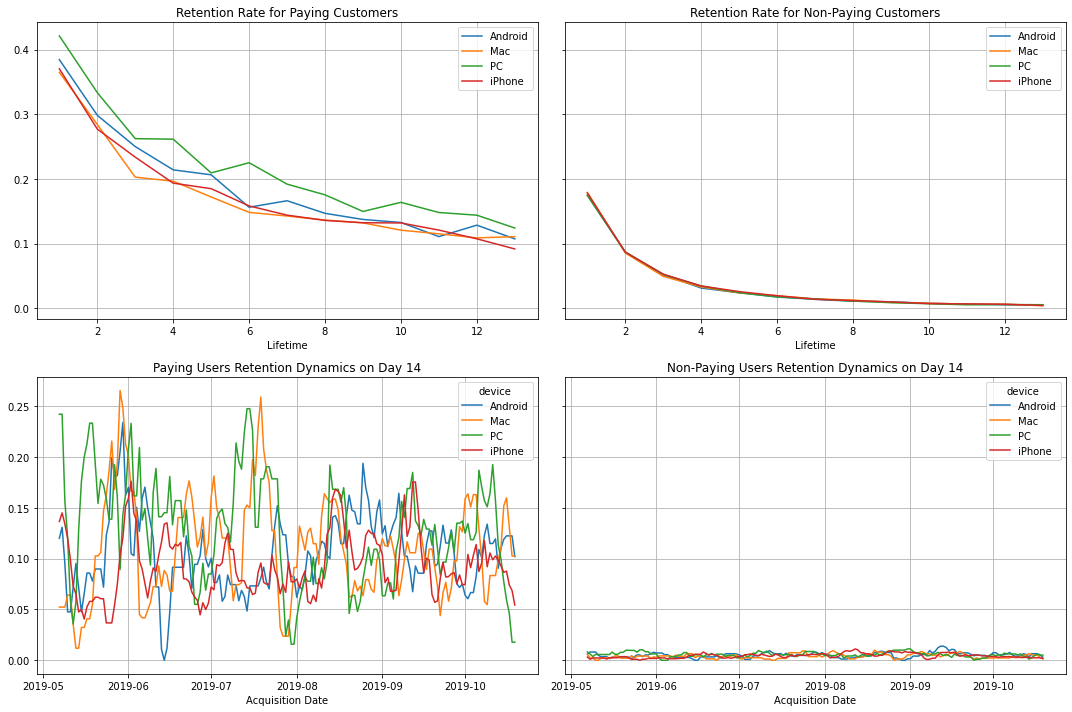

In [53]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days)

iPhone, Android and Mac users convert better than PC users. And PC's retention rate is slightly higher.

# Conclusions

In the course of the study, it was found that marketing costs do not pay off. To find the cause of this issue, we looked at our users by acquisition channel, region, and device.

It was found that the main reasons for advertising ineffectiveness were the high cost of user acquisition from TipTop, FaceBoom and AdNoneSense channels, as well as the increase in the cost of user acquisition from the United States. Despite the higher user conversion from these sources and regions, the retention rate is significantly lower compared to other regions and acquisition channels. As for devices, after analyzing the data, we came to the conclusion that only PC users, given their lower cost, pay off.

The TipTop channel has a very high cost of customer acquisition, which also continues to grow, but at the same time, good retention and conversion rates. And the Faceboom channel has a stable cost of acquisition and a good conversion, but retention is very low. Potentially, if TipTop's exorbitant financial appetites and customer retention from the Faceboom channel are solved, then these channels can be worked with.

If the problems with the above sources cannot be fixed, then you can pay attention to the following traffic sources: lambdaMediaAds, WahooNetBanner and RocketSuperAds. These channels have a stable acquisition cost and they pay off.